In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
from collections import OrderedDict
import seaborn as sns

In [2]:
def search(sql):
    import pandas as pd
    import psycopg2
    conn = psycopg2.connect(database="mimiciv", user="twccntuworkshop", 
                            password="ntuworkshop1210", host="211.73.81.172", 
                            port="5432")
    with conn.cursor() as cur:
        cur.execute(sql)
        name = [desc[0] for desc in cur.description]
        df = pd.DataFrame(cur.fetchall(),columns=name)
    return df

## Basic

In [3]:
sql = """
SELECT *
FROM mimiciv_hosp.patients;
"""

test = search(sql)
test.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,None
2,10000068,F,19,2160,2008 - 2010,None
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,None


## ICU demographics

In [4]:
 sql = """
SELECT
      pat.subject_id
    , adm.hadm_id
    , icu.stay_id
    , ROW_NUMBER() OVER (PARTITION BY pat.subject_id ORDER BY icu.intime) AS icu_stay_num
    , DENSE_RANK() OVER (PARTITION BY pat.subject_id ORDER BY adm.admittime) AS hosp_stay_num
    , CASE
        WHEN FIRST_VALUE(icu.stay_id) OVER icustay_window = icu.stay_id THEN 1
        ELSE 0
      END AS pat_count
    , pat.anchor_age + (EXTRACT(YEAR FROM icu.intime) - pat.anchor_year) AS age
    , pat.gender
    , adm.insurance
    , icu.first_careunit
    , icu.los AS icu_los
    , EXTRACT(HOUR FROM adm.dischtime - adm.admittime)/24+EXTRACT(DAY FROM adm.dischtime - adm.admittime) AS hosp_los
    , pat.dod
    , pat.dod - CAST(adm.dischtime AS DATE) AS days_to_death
    , CASE WHEN pat.dod - CAST(adm.dischtime AS DATE) = 0 THEN 1 ELSE 0 END AS hospital_mortality
    , CASE WHEN pat.dod - CAST(icu.outtime AS DATE) = 0 THEN 1 ELSE 0 END AS icu_mortality
FROM mimiciv_hosp.patients pat
INNER JOIN mimiciv_hosp.admissions adm
    ON pat.subject_id = adm.subject_id
INNER JOIN mimiciv_icu.icustays icu
    ON adm.hadm_id = icu.hadm_id
WINDOW hadm_window AS (PARTITION BY pat.subject_id ORDER BY adm.admittime)
     , icustay_window AS (PARTITION BY pat.subject_id ORDER BY icu.intime)
"""
    
data = search(sql)

data['one_year_mortality'] = data['days_to_death'].notnull().astype(int)

# create a dataframe with the days to death for only the last ICU stay
last_dod = data.groupby('subject_id')[['icu_stay_num']].max().reset_index()
last_dod = last_dod.merge(data[['subject_id', 'icu_stay_num', 'days_to_death']], on=['subject_id', 'icu_stay_num'], how='inner')
last_dod.rename(columns={'days_to_death': 'days_to_death_last_stay_id'}, inplace=True)

data = data.merge(last_dod, how='left', on=['subject_id', 'icu_stay_num'])
del last_dod
data.sort_values(['subject_id', 'icu_stay_num'], inplace=True)

# add a grouping variable for table one so we can have hospital mortality as a group and a row
data['hosp_mort'] = data['hospital_mortality']

# fix some data type issues
int_cols = data.dtypes.values=="Int64"
data.loc[:, int_cols] = data.loc[:, int_cols].astype(float)
data.loc[:, int_cols] = data.loc[:, int_cols].astype(int, errors="ignore")

<ipython-input-4-fdc17428ea3c>:48: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  int_cols = data.dtypes.values=="Int64"


## figure

In [5]:
stay_id = 33214450

### vital

In [6]:
sql =  """
SELECT
    v.stay_id
    , EXTRACT(MINUTE FROM v.charttime - a.admittime) + (EXTRACT(HOUR FROM v.charttime - a.admittime) + EXTRACT(DAY FROM v.charttime - a.admittime) * 24) * 60 AS offset
    , v.heart_rate, v.sbp, v.dbp
    , v.sbp_ni, v.dbp_ni
    , v.resp_rate
    , v.temperature
    , v.spo2
    , v.glucose
FROM mimiciv_hosp.admissions a
INNER JOIN mimiciv_icu.icustays i
    ON a.hadm_id = i.hadm_id
LEFT JOIN mimiciv_derived.vitalsign v
    ON i.stay_id = v.stay_id
"""
vitals = search(sql)

vitals = vitals[vitals.stay_id==stay_id]

vitals.sort_values('offset', inplace=True)


In [7]:
vitals

,stay_id,offset,heart_rate,sbp,dbp,sbp_ni,dbp_ni,resp_rate,temperature,spo2,glucose
6407072,33214450.0,115.0,NaN,NaN,NaN,NaN,NaN,NaN,36.94,NaN,NaN
6407073,33214450.0,115.0,NaN,NaN,NaN,NaN,NaN,NaN,36.94,NaN,NaN
6407074,33214450.0,133.0,92.0,118.0,77.0,118.0,77.0,25.0,None,97.0,NaN
6407075,33214450.0,133.0,92.0,118.0,77.0,118.0,77.0,25.0,None,97.0,NaN
6407076,33214450.0,175.0,92.0,NaN,NaN,NaN,NaN,24.0,None,94.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6407163,33214450.0,1317.0,NaN,118.0,68.0,118.0,68.0,NaN,None,NaN,NaN
6407164,33214450.0,1375.0,91.0,NaN,NaN,NaN,NaN,34.0,36.33,99.0,NaN
6407165,33214450.0,1375.0,91.0,NaN,NaN,NaN,NaN,34.0,36.33,99.0,NaN
6407166,33214450.0,1377.0,NaN,123.0,63.0,123.0,63.0,NaN,None,NaN,NaN


### temp

In [8]:
sql =  """
SELECT
    c.stay_id
    , EXTRACT(MINUTE FROM c.charttime-a.admittime) + (EXTRACT(HOUR FROM c.charttime-a.admittime) + EXTRACT(DAY FROM c.charttime-a.admittime) * 24) * 60 AS offset
    , di.label
    , c.value
    , c.valuenum
    , c.valueuom
FROM mimiciv_hosp.admissions a
INNER JOIN mimiciv_icu.chartevents c
  ON a.hadm_id = c.hadm_id
INNER JOIN mimiciv_icu.d_items di
  ON c.itemid = di.itemid
AND c.itemid IN
(
227632, -- Arctic Sun/Alsius Temp #1 C
227634, -- Arctic Sun/Alsius Temp #2 C
223761 -- Temperature Fahrenheit
)
AND valuenum > 10 AND valuenum < 120
"""

temp = search(sql)
temp = temp[temp.stay_id==stay_id]

idx = temp['valueuom'].isin(['°F'])
temp.loc[idx, 'valuenum'] = (temp.loc[idx, 'valuenum'] - 32)/1.8
temp.sort_values('offset', inplace=True)

### plot

In [9]:
def plot_numeric_data(ax, df_input, plot_info, null_time=None):
    for i, (column, plot_args) in enumerate(plot_info.items()):
        df = df_input[['offset', column]].copy().dropna()
        
        # insert a null when the patient leaves the ICU to break the line in the plot
        if null_time is not None:
            dff = pd.DataFrame([[null_time, None]], columns=['offset', column])
            df = pd.concat([df, dff], ignore_index=True)
        df.sort_values('offset', inplace=True)
        ax.plot(df['offset']/TIME_COEF, df[column], **plot_args)
            
# define colors for the next two figures
sns.set_theme(context='paper', font_scale=2.5, style="whitegrid", palette="pastel")
pal = sns.color_palette('colorblind', 4)
colors = pal.as_hex()
colors

['#0173b2', '#de8f05', '#029e73', '#d55e00']

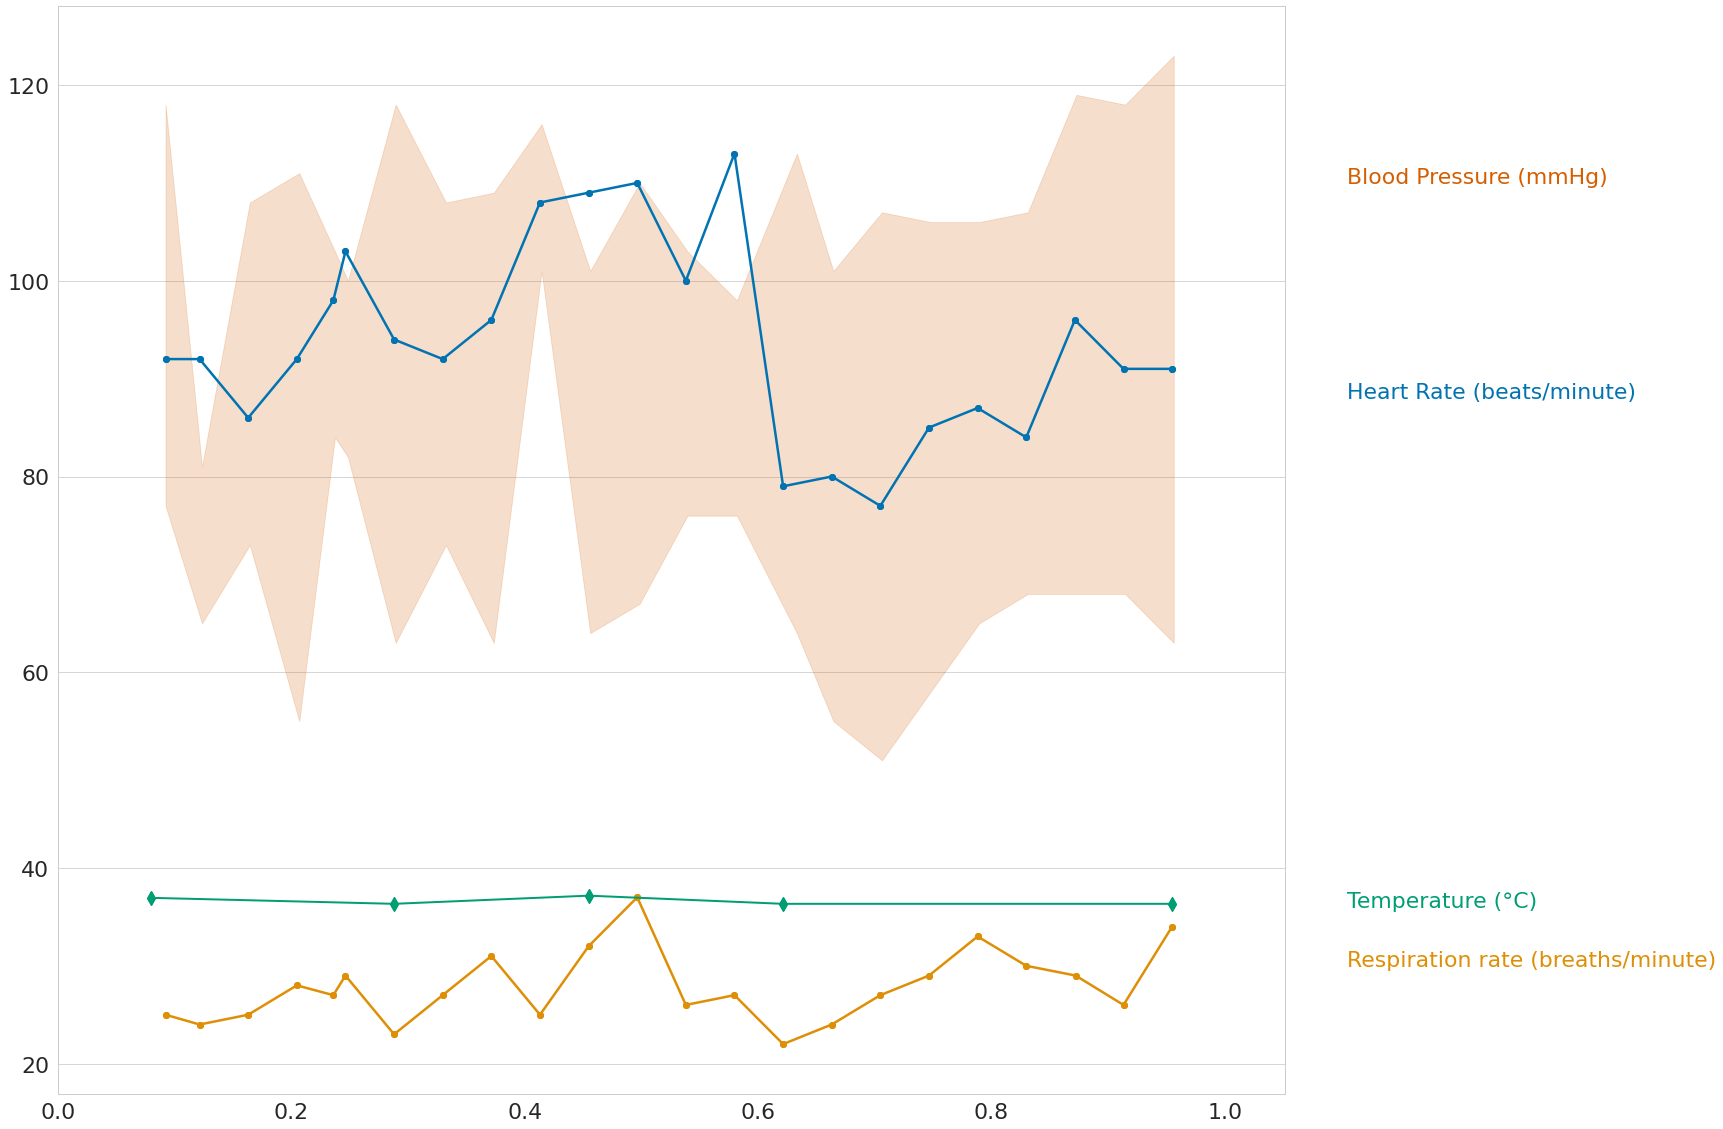

In [10]:
# convert times to a unit consistently
# base time is minutes, so 24*60 -> equiv to converting to days
TIME_COEF = 24*60.0
TIME_UNIT = 'days'

# to prevent a line being drawn between distinct ICU stays, we sometimes add a NaN row to data before plotting
#null_time = 8*24*60
null_time = None

fig = plt.figure(figsize=(22, 20))
plt.rcParams.update({'font.size': 22})
gs = fig.add_gridspec(1, hspace=0)
ax0 = gs.subplots(sharex=True, sharey=False)

xmax = max((vitals.offset/TIME_COEF).values) * 1.1
ax0.set_xlim([0, xmax])

# === vital signs
plot_info_vitals = OrderedDict([
    ['heart_rate', {'label': 'Heart Rate', 'color': colors[0], 'marker': 'o', 'lw': 2.5, 'markersize': 6}],
    ['resp_rate', {'label': 'Respiratory Rate', 'color': colors[1], 'marker': 'o', 'lw': 2.5, 'markersize': 6}],
])
plot_numeric_data(ax0, vitals, plot_info_vitals, null_time=null_time)


# plot shaded dbp/sbp data
bp = vitals[['offset', 'dbp', 'sbp']].dropna().copy()
idx = bp['offset'] < null_time
plot_args = {'color': colors[3], 'alpha': 0.2}
# first half, before ICU discharge
ax0.fill_between(bp.loc[idx, 'offset']/TIME_COEF, bp.loc[idx, 'dbp'], bp.loc[idx, 'sbp'], label='Blood Pressure (mmHg)', **plot_args)
ax0.fill_between(bp.loc[~idx, 'offset']/TIME_COEF, bp.loc[~idx, 'dbp'], bp.loc[~idx, 'sbp'], **plot_args)

# plot temperature
idx = temp['offset'] < null_time
ax0.plot(temp.loc[idx, 'offset']/TIME_COEF, temp.loc[idx, 'valuenum'], label='Temperature (°C)', color=colors[2], marker='d', markersize=10, lw=2)
ax0.plot(temp.loc[~idx, 'offset']/TIME_COEF, temp.loc[~idx, 'valuenum'], color=colors[2], marker='d', markersize=10, lw=2)

# add the legend to the plot itself for better readability
x_loc = xmax*1.05
ax0.text(x_loc, 110, 'Blood Pressure (mmHg)', color=colors[3])
ax0.text(x_loc, 88, 'Heart Rate (beats/minute)', color=colors[0])
ax0.text(x_loc, 36, 'Temperature (°C)', color=colors[2])
ax0.text(x_loc, 30, 'Respiration rate (breaths/minute)', color=colors[1])
ax0.grid(False, axis='x')